![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

### Integrantes:
- Jesus Alberto Parada Perez
- Jorge Esteban Caballero
- Diana Villalba
- Juan Jose Ovalle

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv(
    "https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip"
)

# Preprocesamiento de datos para el taller
data = data.loc[data["Model"].str.contains("Camry")].drop(["Make", "State"], axis=1)
data = data.join(pd.get_dummies(data["Model"], prefix="M"))
data = data.drop(["Model"], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data["Price"]
X = data.drop(["Price"], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
def fit_decision_tree(X, y, max_depth=np.inf, min_samples_leaf=1):
    def mse(y):
        return np.mean((y - np.mean(y)) ** 2)

    def find_best_split(X, y):

        best_mse = np.inf
        features = range(X.shape[1])
        best_split = [0, 0, best_mse]  # j, split, mse

        for j in features:
            feature_values = X.iloc[:, j]
            splits = np.unique(feature_values)[1:]

            for split in splits:
                filter_l = X.iloc[:, j] < split
                y_left = y.loc[filter_l]
                y_right = y.loc[~filter_l]

                mse_left = mse(y_left)
                mse_right = mse(y_right)
                mse_total = (len(y_left) / len(y)) * mse_left + (
                    len(y_right) / len(y)
                ) * mse_right

                if mse_total < best_split[2]:
                    best_split = [j, split, mse_total]
        return best_split

    def build_tree(X, y, depth=0):

        j, split, mse = find_best_split(X, y)
        # Stopping criteria
        if depth == max_depth or len(X) < min_samples_leaf:
            return {
                "split_point": -1,
                "mse": mse,
                "n_samples": len(y),
                "prediccion": np.mean(y),
            }

        filter_l = X.iloc[:, j] < split
        X_left, y_left = X.loc[filter_l], y.loc[filter_l]
        X_right, y_right = X.loc[~filter_l], y.loc[~filter_l]

        tree = {
            "split_var": j,
            "split_point": split,
            "mse": mse,
            "n_samples": X.shape[0],
            "left": build_tree(X_left, y_left, depth + 1),
            "right": build_tree(X_right, y_right, depth + 1),
        }
        return tree

    # Build tree recursively
    decision_tree = build_tree(X, y)
    return decision_tree


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree["split_point"] == -1:
        predicted = predicted * tree["prediccion"]

    else:

        j = tree["split_var"]
        split = tree["split_point"]
        filter_l = X.iloc[:, j] < split
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if (
            X_l.shape[0] == 0
        ):  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree["right"])
        elif (
            X_r.shape[0] == 0
        ):  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree["left"])
        else:
            predicted[filter_l] = tree_predict(X_l, tree["left"])
            predicted[~filter_l] = tree_predict(X_r, tree["right"])

    return predicted


def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [6]:
tree = fit_decision_tree(X_train, y_train, max_depth=10, min_samples_leaf=6)
tree

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


{'split_var': 0,
 'split_point': 2013,
 'mse': 6634331.206860725,
 'n_samples': 7031,
 'left': {'split_var': 0,
  'split_point': 2012,
  'mse': 4284524.846836398,
  'n_samples': 1973,
  'left': {'split_var': 1,
   'split_point': 99171,
   'mse': 3078272.5679919245,
   'n_samples': 1457,
   'left': {'split_var': 0,
    'split_point': 2008,
    'mse': 2893635.896004809,
    'n_samples': 695,
    'left': {'split_var': 1,
     'split_point': 50031,
     'mse': 2499758.9599264697,
     'n_samples': 204,
     'left': {'split_var': 0,
      'split_point': 2006,
      'mse': 2907325.3159722225,
      'n_samples': 24,
      'left': {'split_var': 1,
       'split_point': 39086,
       'mse': 1009501.742857143,
       'n_samples': 12,
       'left': {'split_point': -1,
        'mse': 300090.4,
        'n_samples': 5,
        'prediccion': 9612.6},
       'right': {'split_var': 0,
        'split_point': 2004,
        'mse': 425421.2571428572,
        'n_samples': 7,
        'left': {'split_point':

In [7]:
#train
y_pred_train = tree_predict(X_train, tree)
MSE_tree_train = calculate_mse(y_train, y_pred_train)
print(f"MSE train: {MSE_tree_train}")
RMSE_tree_train = calculate_rmse(y_train, y_pred_train)
print(f"RMSE train: {RMSE_tree_train}")
MAE_tree_train = calculate_mae(y_train, y_pred_train)
print(f"MAE train: {MAE_tree_train}")

#test
y_pred = tree_predict(X_test, tree)

MSE_tree = calculate_mse(y_test, y_pred)
print(f"MSE: {MSE_tree}")
RMSE_tree = calculate_rmse(y_test, y_pred)
print(f"RMSE: {RMSE_tree}")
MAE_tree = calculate_mae(y_test, y_pred)
print(f"MAE: {MAE_tree}")

MSE train: 1733749.6978807459
RMSE train: 1316.719293502129
MAE train: 973.9725301988418
MSE: 2870635.1268629422
RMSE: 1694.2948760068132
MAE: 1231.8083241449692


#### Solución
------------------------------
El árbol de regresión manual presenta overfitting ya que su desempeño es mejor en el set de entrenamiento y se deteriora su poder de predicción en el set de evaluación.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Celda 2
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [
    np.random.choice(a=n_samples, size=n_samples, replace=True)
    for _ in range(1, n_B + 1)
]
samples

# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=10, min_samples_leaf=6, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_train = pd.DataFrame(index=y_train.index, columns=[list(range(n_B))]) #para set de train
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))]) # para set de test

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de train
for i, sample in enumerate(samples):
    X_train_2 = X_train.iloc[sample, :]
    y_train_2 = y_train.iloc[sample]
    treereg.fit(X_train_2, y_train_2)
    y_pred_train.iloc[:, i] = treereg.predict(X_train)

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_2 = X_train.iloc[sample, :]
    y_train_2 = y_train.iloc[sample]
    treereg.fit(X_train_2, y_train_2)
    y_pred.iloc[:, i] = treereg.predict(X_test)

# Desempeño de cada árbol
from sklearn.metrics import mean_squared_error

for i in range(n_B):
    print(
        "Árbol ",
        i + 1,
        "tiene un error: ",
        np.sqrt(mean_squared_error(y_pred.iloc[:, i], y_test)),
    )

# Error al promediar las predicciones de todos los árboles
RMSE_bagging = np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
print(f"El error al promediar los 10 arboles es: {RMSE_bagging}")

RMSE_bagging_train = np.sqrt(mean_squared_error(y_train, y_pred_train.mean(axis=1)))
print(f"El error al promediar los 10 arboles en el set de train es: {RMSE_bagging_train}")

Árbol  1 tiene un error:  1697.7724019966938
Árbol  2 tiene un error:  1713.0608604670924
Árbol  3 tiene un error:  1735.0305571715783
Árbol  4 tiene un error:  1683.6390102748408
Árbol  5 tiene un error:  1733.0555501122437
Árbol  6 tiene un error:  1703.2046531416188
Árbol  7 tiene un error:  1665.7123119374487
Árbol  8 tiene un error:  1713.063093455765
Árbol  9 tiene un error:  1714.0205693624139
Árbol  10 tiene un error:  1712.114482440971
El error al promediar los 10 arboles es: 1590.8008190742087
El error al promediar los 10 arboles en el set de train es: 1344.3381529203614


#### Solución
------------------------------
El desempeño de los 10 árboles de regresión es menor, es decir, tienen mayor error de predicción, que cuando se utiliza Bagging como método de ensamblaje.

El error en Bagging es de 1590.8 con una profundida máxima de 10 y minimo 6 muestras en la hoja.

Si lo comparamos con el modelo anterior, el RMSE de Bagging es menor que el árbol de regresión.

Con respecto al overfit, se observa que el desempeño del modelo continua siendo mejor en el set de entrenamiento, lo que sugiere overfitting, sin embargo, el overfitting disminuye por el Bagging mejora el desempeño en el set de evaluación.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [9]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingRegressor

n_features = X_train.shape[1]
bagreg = BaggingRegressor(
    DecisionTreeRegressor(
        max_features=int(np.ceil(np.log(n_features))), max_depth=10, min_samples_leaf=6
    ),
    n_estimators=10,
    bootstrap=True,
    oob_score=True,
    random_state=1,
)


# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

mse_bagging_lib = np.mean((y_test - y_pred) ** 2)
print("Bagging con librería MSE:", mse_bagging_lib)
RMSE_RF_bagging_lib = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Bagging con librería RMSE:", RMSE_RF_bagging_lib)


# Cálculo del error the out-of-bag con el R-cuadrado (no con el MSE)
error_oob = bagreg.oob_score_
print("Bagging con librería Error OOB ", error_oob)


Bagging con librería MSE: 2442044.8914093357
Bagging con librería RMSE: 1562.7043518878852
Bagging con librería Error OOB  0.6771252059461725


In [10]:
y_pred_or = bagreg.predict(X_train)

mse_bagging_lib_or = np.mean((y_train - y_pred_or) ** 2)
print("Bagging con librería MSE:", mse_bagging_lib_or)
RMSE_RF_bagging_lib_or = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("Bagging con librería RMSE:", RMSE_RF_bagging_lib_or)

Bagging con librería MSE: 2021676.2927953342
Bagging con librería RMSE: 1421.8566358094386


#### Solución
------------------------------
El módelo se estima con un maximo de 3 features a analizar en cada nodo del árbol y para 10 árboles para mantener las comparaciones. Como resultado se tiene:

- El RMSE en Bagging con libreria es de 1562.7 con una profundida máxima de 10 y minimo 6 muestras en la hoja.
- Si lo comparamos con los modelos anteriores, el RMSE de Bagging con libreria es menor que el de Baggin manual y el arbol de regresión manual.

Este modelo tiene mejor desempeño que los modelos anteriores.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [11]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de regresión
reg = RandomForestRegressor()

# Ajuste del modelo con los datos de entrenamiento
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse_RF_lib = np.mean((y_test - y_pred) ** 2)
print("Random forest con librería MSE:", mse_RF_lib)
RMSE_RF_lib = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Random forest con librería RMSE:", RMSE_RF_lib)

# Impresión de desempeño del modelo usando la función cross_val_score

print(
    f"Desempeño del modelo en Train:  {pd.Series(cross_val_score(reg, X_train, y_train, cv=10)).describe()}"
)
print(
    f"Desempeño del modelo en Test:  {pd.Series(cross_val_score(reg, X_test, y_test, cv=10)).describe()}"
)

Random forest con librería MSE: 3088732.730251257
Random forest con librería RMSE: 1757.4790838730505
Desempeño del modelo en Train:  count    10.000000
mean      0.801699
std       0.022202
min       0.765807
25%       0.789810
50%       0.801373
75%       0.819741
max       0.829525
dtype: float64
Desempeño del modelo en Test:  count    10.000000
mean      0.793732
std       0.020114
min       0.748417
25%       0.786891
50%       0.796577
75%       0.804088
max       0.817745
dtype: float64


In [12]:
y_pred_or = reg.predict(X_train)

mse_RF_lib_or = np.mean((y_train - y_pred_or) ** 2)
print("Random forest con librería MSE:", mse_RF_lib_or)
RMSE_RF_lib_or = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("Random forest con librería RMSE:", RMSE_RF_lib_or)

Random forest con librería MSE: 429716.62081926217
Random forest con librería RMSE: 655.5277422193985


#### Solución
------------------------------
Se estima el módelo Random Forest sin calibrar los parametros y se encuentra que no hay overfittng. Además, dado que no se calibran los paramteros, el desempeño del modelo **NO** es mejor que los modelos anteriores.

- El RMSE en RF es de 1759.34 

Este modelo tiene peor desempeño que los modelos anteriores.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'RMSE')

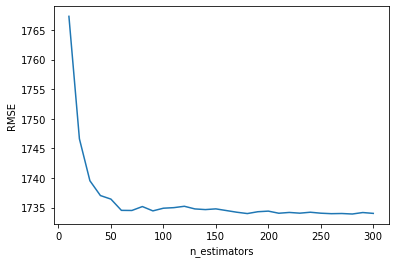

In [13]:
# Celda 5

from sklearn.metrics import make_scorer, mean_squared_error

rmse = make_scorer(
    lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred)),
    greater_is_better=False,
)
import matplotlib.pyplot as plt

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
RMSE_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    RMSE_scores.append(
        cross_val_score(
            reg, X_train, y_train, cv=5, scoring=rmse
        ).mean()
    )

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
RMSE_scores = [-x for x in RMSE_scores]
plt.plot(estimator_range, RMSE_scores)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")

In [14]:
pos = RMSE_scores.index(min(RMSE_scores))
estimator_range[pos]

280

Text(0, 0.5, 'RMSE')

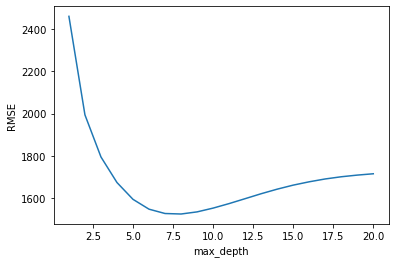

In [15]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth = range(1, 21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
RMSE_scores_2 = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for depths in depth:
    reg = RandomForestRegressor(
        n_estimators=280, max_depth=depths, random_state=1, n_jobs=-1
    )
    RMSE_scores_2.append(
        cross_val_score(
            reg, X_train, y_train, cv=5, scoring=rmse
        ).mean()
    )

# Gráfica del desempeño del modelo vs la cantidad de max_features
RMSE_scores_2 = [-x for x in RMSE_scores_2]
plt.plot(depth, RMSE_scores_2)
plt.xlabel("max_depth")
plt.ylabel("RMSE")

In [16]:
pos_2 = RMSE_scores_2.index(min(RMSE_scores_2))
depth[pos_2]

8

Text(0, 0.5, 'RMSE')

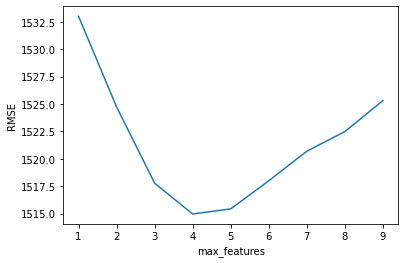

In [17]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols = X_train.shape[1]
feature_range = range(1, feature_cols + 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
RMSE_scores_3 = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(
        n_estimators=280, max_depth=8, max_features=feature, random_state=1, n_jobs=-1
    )
    RMSE_scores_3.append(
        cross_val_score(
            reg, X_train, y_train, cv=5, scoring=rmse
        ).mean()
    )

# Gráfica del desempeño del modelo vs la cantidad de max_features
RMSE_scores_3 = [-x for x in RMSE_scores_3]
plt.plot(feature_range, RMSE_scores_3)
plt.xlabel("max_features")
plt.ylabel("RMSE")

In [18]:
pos_3 = RMSE_scores_3.index(min(RMSE_scores_3))
feature_range[pos_3]

4

In [19]:
# Definición del modelo con los parámetros max_features=4 y n_estimators=280 y max_depth=8
reg = RandomForestRegressor(
    n_estimators=280, max_depth=8, max_features=4, random_state=1, n_jobs=-1
)

# Ajuste del modelo con los datos de entrenamiento
reg.fit(X_train, y_train)

# Evaluación del modelo con los datos de prueba
y_pred = reg.predict(X_test)

# Cálculo del error cuadrático medio
mse_RF_params = np.mean((y_test - y_pred) ** 2)
print("Random forest Calibrado MSE:", mse_RF_params)
RMSE_RF_params = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Random forest Calibrado RMSE:", RMSE_RF_params)

Random forest Calibrado MSE: 2409104.9356840467
Random forest Calibrado RMSE: 1552.1291620493594


In [20]:
y_pred_or = reg.predict(X_train)

mse_RF_params_or = np.mean((y_train - y_pred_or) ** 2)
print("Random forest Calibrado MSE:", mse_RF_params_or)
RMSE_RF_params_or = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("Random forest Calibrado RMSE:", RMSE_RF_params_or)

Random forest Calibrado MSE: 1917830.2145172553
Random forest Calibrado RMSE: 1384.8574708312965


In [21]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame(
    {"feature": X_train.columns, "importance": reg.feature_importances_}
).sort_values("importance")

,feature,importance
5,M_CamryL,0.001501
4,M_CamryBase,0.001515
2,M_Camry,0.006421
6,M_CamryLE,0.007333
8,M_CamryXLE,0.017407
7,M_CamrySE,0.017763
3,M_Camry4dr,0.057330
1,Mileage,0.373887
0,Year,0.516843


#### Solución
------------------------------
El módelo se estima con un maximo de 4 features a analizar en cada nodo del árbol y para 280 árboles y profundidad maxima de 8. Como resultado se tiene:

- El RMSE en RF calibrado es de 1552.12
- Si lo comparamos con los modelos anteriores, este modelo es de mejor desempeño que los anteriores.

La variable de mayor importancia es el año, las millas y el modelo Camry4dr.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [22]:
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBRegressor

xgbreg = XGBRegressor()
xgbreg.fit(X_train, y_train)
y_pred = xgbreg.predict(X_test)


mse_XGB = np.mean((y_test - y_pred) ** 2)
print("XGBoost con librería MSE:", mse_XGB)
RMSE_XGB = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("XGBoost con librería RMSE:", RMSE_XGB)

XGBoost con librería MSE: 2629001.8449284737
XGBoost con librería RMSE: 1621.4197004256714


In [23]:
y_pred_or = xgbreg.predict(X_train)

mse_XGB_or = np.mean((y_train - y_pred_or) ** 2)
print("XGBoost con librería MSE:", mse_XGB_or)
RMSE_XGB_or = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("XGBoost con librería RMSE:", RMSE_XGB_or)

XGBoost con librería MSE: 1315628.7787272697
XGBoost con librería RMSE: 1147.0086219062478


In [24]:
xgbreg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### Solución
------------------------------
Las métricas del XGBoost por default dan peores que el Random Forest Calibrados. Esto es dentro de lo normal. Igualmente, se observa un Overfit del modelo por la diferencia de desempeño entre Train y Test

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [25]:
# Celda 7
from sklearn.model_selection import RandomizedSearchCV


# Se crea un diccionario de hiper parametros
parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1],
    "colsample_bytree": [0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1],
    "gamma": [
        0,
        0.01,
        0.05,
        0.1,
        0.25,
        0.5,
        0.75,
        0.9,
        1,
        2,
        3,
        4,
        5,
        10,
        25,
        50,
        75,
        100,
    ],
}

In [26]:
# Se adapta el proceso a una función para fácilmente aplicarla a los hiper parámetros


def tune_one_param_xgboost(param_name, params=parameters):
    try:
        estimator_list = params[param_name].copy()
    except:
        print("El nombre del parámetro no está dentro del grid de hiperparametros")
        return None
    RMSE_scores = []
    for estimator in estimator_list:
        if param_name == "learning_rate":
            reg = XGBRegressor(random_state=1324, n_jobs=-1, learning_rate=estimator)
        elif param_name == "gamma":
            reg = XGBRegressor(random_state=1324, n_jobs=-1, gamma=estimator)
        elif param_name == "colsample_bytree":
            reg = XGBRegressor(random_state=1324, n_jobs=-1, colsample_bytree=estimator)

        RMSE_scores.append(
            cross_val_score(reg, X_train, y_train, cv=5, scoring=rmse).mean()
        )

    # Gráfica del desempeño del modelo vs la cantidad de n_estimators
    RMSE_scores = [-x for x in RMSE_scores]
    plt.plot(estimator_list, RMSE_scores)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")

    pos = RMSE_scores.index(min(RMSE_scores))
    print(f"Mejor valor para {param_name}: ", estimator_list[pos])
    return estimator_list[pos]

Mejor valor para learning_rate:  0.05


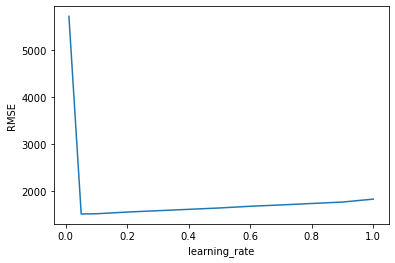

In [27]:
best_lr=tune_one_param_xgboost('learning_rate')

El error empieza alto y llega a un mínimo, a partir del cual sube lentamente. Parece ser un valor relativamente flexible en tanto a que los RMSE cercanos al mínimo por la derecha no empeoran sustancialmente el modelo.

Mejor valor para colsample_bytree:  0.4


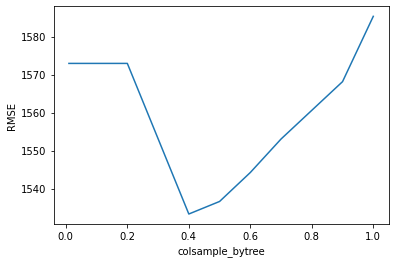

In [28]:
best_colsample=tune_one_param_xgboost('colsample_bytree')

En este caso, el RMSE de los modelos no cambia mucho. El mínimo se nota cual es pero la diferencia entre sus valores es menos del 20%. Dejando los demás parámetros contantes, no parece mover el error tanto como el learning rate (que en sus valores más bajos, si se encuentra fuertemente alejado).

Mejor valor para gamma:  0


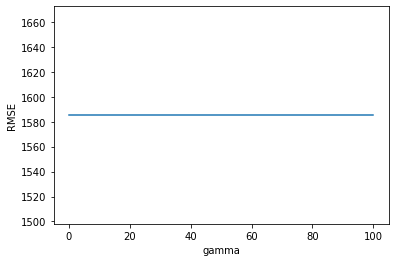

In [29]:
best_gamma=tune_one_param_xgboost('gamma')

El gamma no parece afectar sustancialmente el modelo, tiende a tener más o menos el mismo comportamiento para estos datos. El error aumenta al aumentar gamma, dado que el gama elegido es el menor gamma de los datos.

In [30]:
# Se ajusta un modelo con esos parámetros:
xgbreg_tuned = XGBRegressor(
    random_state=1324,
    gamma=best_gamma,
    colsample_bytree=best_colsample,
    learning_rate=best_lr,
)

In [32]:
xgbreg_tuned.fit(X_train, y_train)
y_pred = xgbreg_tuned.predict(X_test)


mse_xg_params = np.mean((y_test - y_pred) ** 2)
print("MSE:", mse_xg_params)
RMSE_xg_params = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE:", RMSE_xg_params)

MSE: 2451602.068003865
RMSE: 1565.7592624678498


In [33]:
y_pred_or = xgbreg_tuned.predict(X_train)

mse_xg_params = np.mean((y_train - y_pred_or) ** 2)
print("MSE:", mse_xg_params)
RMSE_xg_params = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("RMSE:", RMSE_xg_params)

MSE: 2152789.0070452653
RMSE: 1467.2385651438096


In [34]:
print(
    "colsample_bytree: ",
    best_colsample,
    "\ngamma\t\t: ",
    best_gamma,
    "\nlearning_rate\t: ",
    best_lr,
)

colsample_bytree:  0.4 
gamma		:  0 
learning_rate	:  0.05


De forma adicional, se realiza el ajuste para el XGB regressor con Random Search en el mismo grid de hiper parámetros (se espera de diferente pues se optimiza para "todos" los hiper parámetros a la vez):

In [35]:
xgbreg_base = XGBRegressor(random_state=1)

xgbreg_rs = RandomizedSearchCV(
    xgbreg_base,
    parameters,
    cv=5,
    scoring=rmse,
    n_jobs=-1,
   random_state=1
)

xgbreg_rs.fit(X_train, y_train)
y_pred = xgbreg_rs.predict(X_test)


mse_XGB_calibrado = np.mean((y_test - y_pred) ** 2)
print("MSE:", mse_XGB_calibrado)
RMSE_XGB_calibrado = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE:", RMSE_XGB_calibrado)

MSE: 2405947.0309344335
RMSE: 1551.1115469025538


In [36]:
xgbreg_rs.best_params_

{'learning_rate': 0.05, 'gamma': 75, 'colsample_bytree': 0.5}

In [37]:
y_pred_or = xgbreg_rs.predict(X_train)

mse_XGB_calibrado_or = np.mean((y_train - y_pred_or) ** 2)
print("XGBoost Calibrado MSE:", mse_XGB_calibrado_or)
RMSE_XGB_calibrado_or = np.sqrt(np.mean((y_train - y_pred_or) ** 2))
print("XGBoost Calibrado RMSE:", RMSE_XGB_calibrado_or)

XGBoost Calibrado MSE: 2039635.5998521212
XGBoost Calibrado RMSE: 1428.1581144439579


#### Solución
------------------------------
Después de realizar la calibración de hiperparámetros, se encontraron los siguientes mejores valores: learning_rate de 0.05, gamma de 0 y colsample_bytree de 0.9.

Durante el proceso de ajuste, se observó que el RMSE varió significativamente al ajustar el learning_rate. Los valores más bajos de learning_rate (0.01) resultaron en un RMSE mucho más alto (5722.26), mientras que un learning_rate de 0.05 alcanzó el mejor desempeño con un RMSE de 1513.66. Aumentar el learning_rate más allá de 0.05 llevó a un aumento en el RMSE.

En cuanto al parámetro gamma, no se observaron diferencias en el RMSE al variar su valor dentro del rango de valores definido.

El parámetro colsample_bytree mostró un comportamiento interesante, donde un valor de 0.9 resultó en el mejor desempeño (RMSE de 1508.05), mientras que valores más bajos o igual a 1 mostraron un empeoramiento en el desempeño del modelo.

El modelo XGBoost con estos hiperparámetros optimizados tiene un RMSE de 1554.36, lo que indica una mejora en el desempeño respecto al modelo sin calibrar.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

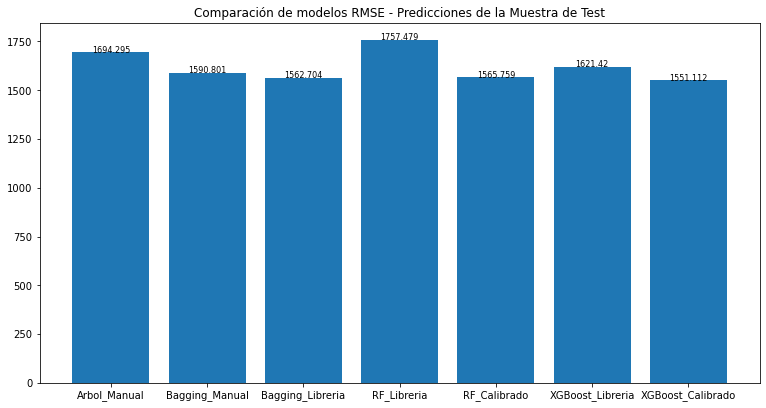

In [38]:
#graficar RMSE de cada modelo muestra de Test

import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,5])

ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos RMSE - Predicciones de la Muestra de Test")
ejeX = ['Arbol_Manual', 'Bagging_Manual', 'Bagging_Libreria', 'RF_Libreria', 'RF_Calibrado', 'XGBoost_Libreria', 'XGBoost_Calibrado']
ejeY = [RMSE_tree, RMSE_bagging, RMSE_RF_bagging_lib, RMSE_RF_lib, RMSE_RF_params,RMSE_XGB, RMSE_XGB_calibrado ]
ax.bar(ejeX,ejeY)
# def addlabels(x,y,plotP):
#     for i in range(len(x)):
#         plotP.text(i,y[i],y[i])
# addlabels(ejeX,ejeY,plt)
for i, rmse in enumerate(ejeY):
    plt.text(i, rmse + 0.02, str(round(rmse, 3)), ha='center', fontsize=8)
plt.tight_layout()
plt.show()

#### Solución
------------------------------
Al comparar los valores del RMSE de cada modelo podemos observar que el modelo de Random Forest Calibrado es el que mejor se ajusta a los datos, seguido del XGBoost Calibrado y el modelo the bagging usando la libreria. No obstante, el Random forest (sin calibrar) presenta un overfit extremo al tener un error de la mitad en entrenamiento contra prueba. Algo similar ocurrió con el XGBoost sin calibrar

El mejor modelo parace estar entre el XGBoost calibrado y el Random Forest calibrados, al tener un desempeño similar en ambas muestras. Durante las pruebas que realizamos, el mejor modelo variaba entre ambos.

El XGBoost se entrenaba más rápido, por lo que en la vida real posiblemente se eligiría ese (tienen desempeños similares po al entrenar más rápido termina siendo un modelo más económico en el largo plazo). Además, tiene el comportamiento más similar por métricas entre ambos sets

En las pruebas, se notó que los modelos sin calibrar tenían una mayor tendencia al overfit que aquellos que se validaron algunos de los parámetros.

Los modelos de peor desempeños con modelos propensos al overfit, como el Arbol manual y o un random forest sin tunear. El desempeño mejora con el boosting y el ensemble, pero requiere el tuneo de hyper parámetros para evadir las tendencias de overfitting.


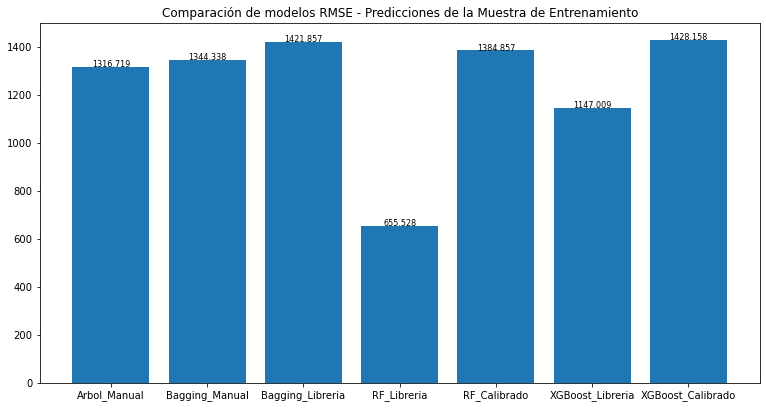

In [39]:
#graficar RMSE de cada modelo muestra de Entrenamiento

import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,5])

ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos RMSE - Predicciones de la Muestra de Entrenamiento")
ejeX = ['Arbol_Manual', 'Bagging_Manual', 'Bagging_Libreria', 'RF_Libreria', 'RF_Calibrado', 'XGBoost_Libreria', 'XGBoost_Calibrado']
ejeY = [RMSE_tree_train, RMSE_bagging_train, RMSE_RF_bagging_lib_or, RMSE_RF_lib_or, RMSE_RF_params_or, RMSE_XGB_or, RMSE_XGB_calibrado_or ]
ax.bar(ejeX,ejeY)
# def addlabels(x,y,plotP):
#     for i in range(len(x)):
#         plotP.text(i,y[i],y[i])
# addlabels(ejeX,ejeY,plt)
for i, rmse in enumerate(ejeY):
    plt.text(i, rmse + 0.02, str(round(rmse, 3)), ha='center', fontsize=8)
plt.tight_layout()

plt.show()